In [121]:
import os
import glob
import random
import pytorch_lightning as pl
import torch
import torch.nn as nn
import skimage.io
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.functional import F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pytorch_lightning import loggers as pl_loggers

### Load Tensorboard extension

In [78]:
%load_ext tensorboard

### Define Transforms

In [96]:
MEAN_NORMALIZE = torch.tensor([0.485, 0.456, 0.406, 0.485, 0.456, 0.406])
STD_NORMALIZE = torch.tensor([0.229, 0.224, 0.225, 0.229, 0.224, 0.225])

In [93]:
train_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225, 0.229, 0.224, 0.225],)
])

validation_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225, 0.229, 0.224, 0.225],)
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225, 0.229, 0.224, 0.225],)
])

### Dataset class

In [61]:
class RansomwareDetectionDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path_1 = self.image_paths[index][0]
        image_path_2 = self.image_paths[index][1]
        image_1 = skimage.io.imread(image_path_1)
        image_2 = skimage.io.imread(image_path_2)
        image = np.concatenate((image_1, image_2), axis=2)

        label = image_path_1.split("/")[2]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create CNN

In [66]:
class BaselineNetwork(pl.LightningModule):
    def __init__(self, number_of_classes, image_size):
        super().__init__()
        
        self.image_size = image_size
        self.final_size = image_size // 2

        self.conv1 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(in_features=16 * self.final_size * self.final_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=number_of_classes)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/train", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/train", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/valid", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/valid", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.0001, momentum=0.9)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=2)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "Loss/valid"
        }


### Create train, validation, test sets

In [7]:
def split(split_dataset):
    train_image_paths, valid_image_paths = train_test_split(split_dataset, train_size=0.7, shuffle=True)

    print(f"Train size: {len(train_image_paths)}")
    print(f"Valid size {len(valid_image_paths)}")

    return train_image_paths, valid_image_paths

In [8]:
def index_to_class(classes):
    idx_to_class = {i:j for i, j in enumerate(classes)}
    class_to_idx = {value:key for key,value in idx_to_class.items()}
    print(f"Class to idx: {class_to_idx}")
    print(f"Idx to class: {idx_to_class}")

    return idx_to_class, class_to_idx

In [102]:
def create_path_datasets(benign_folders, ransomware_folders, sample_count):
    random.seed(42)

    benign_paths = list()
    ransomware_paths = list()
    classes = list()

    benign_paths_1 = glob.glob(os.path.join(benign_folders[0], "*"))
    benign_paths_2 = glob.glob(os.path.join(benign_folders[1], "*"))
    for i in range(sample_count):
        benign_path_1 = benign_paths_1[i]
        benign_path_2 = benign_paths_2[i]
        benign_paths.append((benign_path_1, benign_path_2))
        classes.append(benign_path_1.split("/")[2])
    
    ransomware_paths_1 = glob.glob(os.path.join(ransomware_folders[0], "*"))
    ransomware_paths_2 = glob.glob(os.path.join(ransomware_folders[1], "*"))
    for i in range(sample_count):
        ransomware_path_1 = ransomware_paths_1[i]
        ransomware_path_2 = ransomware_paths_2[i]
        ransomware_paths.append((ransomware_path_1, ransomware_path_2))
        classes.append(ransomware_path_1.split("/")[2])

    random.shuffle(benign_paths)
    random.shuffle(ransomware_paths)

    test_benign_image_paths, train_valid_benign_image_paths = benign_paths[:10], benign_paths[10:]
    test_ransomware_image_paths, train_valid_ransomware_image_paths = ransomware_paths[:10], ransomware_paths[10:]

    test_image_paths = test_benign_image_paths + test_ransomware_image_paths
    train_valid_image_paths = train_valid_benign_image_paths + train_valid_ransomware_image_paths

    classes = list(set(classes))

    print(f"Test dataset len: {len(test_image_paths)}")
    print(f"Train validation dataset len: {len(train_valid_image_paths)}")
    print(f"Path example: {train_valid_image_paths[0]}")
    print(f"Class example: {classes[0]}")

    train_image_paths, valid_image_paths = split(train_valid_image_paths)
    idx_to_class, class_to_idx = index_to_class(classes)

    return train_image_paths, valid_image_paths, test_image_paths, idx_to_class, class_to_idx

### Create train validation dataloader

In [10]:
def create_dataloaders(train_dataset, validation_dataset, batch_size=4):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=0)

    print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
    print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")

    return train_dataloader, validation_dataloader

### Visualitiona of the data loader data

In [11]:
def visualize_data_loader(train_loader, validation_loader):
    rows = 2
    columns = 2
    fig = plt.figure(figsize=(8, 8))

    train_iter = iter(train_loader)
    valid_iter = iter(validation_loader)

    for index in range(0, 4):
        train_image, train_label = next(train_iter)
        valid_image, valid_label = next(valid_iter)
        ax = fig.add_subplot(rows, columns, index + 1)

        x_train = train_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        plt.imshow(x_train.numpy().transpose(1, 2, 0))

        x_valid = valid_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        plt.imshow(x_valid.numpy().transpose(1, 2, 0))

### Eval Model with test dataset

In [128]:
def eval_model(test_dataloader, idx_to_class, model):
    fig = plt.figure(figsize=(25, 7))
    spec = fig.add_gridspec(ncols=10, nrows=2)

    test_iter = iter(test_dataloader)

    y_pred = list()
    y_true = list()

    count = 0
    for row in range(2):
        for col in range(10):
            batch, label = next(test_iter)
            pred = model(batch)
            pred = pred.argmax(dim=1)

            ax = fig.add_subplot(spec[row, col])

            x = batch[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
            x_numpy = x.numpy()
            sub_images = np.split(x_numpy, 2, axis=0)
            # print(x_numpy.shape)
            # print(sub_images[0].shape)
            # print(sub_images[1].shape)
            ax.imshow(sub_images[0].transpose(1, 2, 0))
            ax.set_title(f'label: {idx_to_class[label.item()]}, \n pred: {idx_to_class[pred.item()]}')

            y_pred.append(idx_to_class[pred.item()])
            y_true.append(idx_to_class[label.item()])

            count += 1

    print(classification_report(y_true, y_pred))

## Experiment for gramian angular simulation

In [103]:
benign_gaf_paths = ("features/images/benign/gaf/branch_instructions", "features/images/benign/gaf/cache_references")
ransomware_gaf_paths = ("features/images/ransomware/gaf/branch_instructions", "features/images/ransomware/gaf/cache_references")

benign_samples = 0
ransomware_samples = 0
sample_count = list()

for i in range(len(benign_gaf_paths)):
    benign_sample_count = len(glob.glob(os.path.join(benign_gaf_paths[i], "*")))
    sample_count.append(benign_sample_count)
    benign_samples += benign_sample_count

    ransomware_sample_count = len(glob.glob(os.path.join(ransomware_gaf_paths[i], "*")))
    sample_count.append(ransomware_sample_count)
    ransomware_samples += ransomware_sample_count

print("Benign samples", benign_samples)
print("Ransomware samples", ransomware_samples)
print("Min. samples", min(sample_count))

Benign samples 404
Ransomware samples 404
Min. samples 176


In [104]:
train_gaf_image_paths, valid_gaf_image_paths, test_gaf_image_paths, gaf_idx_to_class, gaf_class_to_idx = create_path_datasets(benign_gaf_paths, ransomware_gaf_paths, min(sample_count))

train_gaf_dataset = RansomwareDetectionDataset(train_gaf_image_paths, gaf_class_to_idx, transform=train_transformations)
validation_gaf_dataset = RansomwareDetectionDataset(valid_gaf_image_paths, gaf_class_to_idx, transform=validation_transformations)
test_gaf_dataset = RansomwareDetectionDataset(test_gaf_image_paths, gaf_class_to_idx, transform=test_transformation)

print(f"Tensor shape of the image: {train_gaf_dataset[1][0].shape}")
print(f"Label of the image: {gaf_idx_to_class[train_gaf_dataset[1][1]]}")

Test dataset len: 20
Train validation dataset len: 332
Path example: ('features/images/benign/gaf/branch_instructions/benign_226.jpg', 'features/images/benign/gaf/cache_references/benign_52.jpg')
Class example: benign
Train size: 232
Valid size 100
Class to idx: {'benign': 0, 'ransomware': 1}
Idx to class: {0: 'benign', 1: 'ransomware'}
Tensor shape of the image: torch.Size([6, 50, 50])
Label of the image: benign


In [105]:
train_gaf_loader, validation_gaf_loader = create_dataloaders(train_gaf_dataset, validation_gaf_dataset)

Train dataloader shape torch.Size([4, 6, 50, 50])
Validation dataloader shape torch.Size([4, 6, 50, 50])


In [112]:
gaf_model = BaselineNetwork(number_of_classes=len(gaf_idx_to_class), image_size=50)

In [113]:
checkpoint_callback_gaf = pl.callbacks.ModelCheckpoint(
    dirpath="checkpoints/MULTI-GAF",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="Loss/valid",
    mode="min"
)

logger_gaf = pl_loggers.TensorBoardLogger("logs/", name="MULTI-GAF")
trainer_gaf = pl.Trainer(max_epochs=25, log_every_n_steps=1, logger=logger_gaf, callbacks=[checkpoint_callback_gaf])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [114]:
trainer_gaf.fit(gaf_model, train_dataloaders=train_gaf_loader, val_dataloaders=validation_gaf_loader)


  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 660   
1 | conv2   | Conv2d           | 1.7 K 
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 1.3 M 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.164     Total estimated model params size (MB)
/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 83/83 [00:02<00:00, 30.07it/s, loss=0.691, v_num=4, Loss/valid=0.684, Accuracy/valid=0.540, Loss/train=0.697, Accuracy/train=0.483]

Epoch 0, global step 57: Loss/valid reached 0.68365 (best 0.68365), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 1: 100%|██████████| 83/83 [00:03<00:00, 21.38it/s, loss=0.671, v_num=4, Loss/valid=0.659, Accuracy/valid=0.660, Loss/train=0.678, Accuracy/train=0.565]

Epoch 1, global step 115: Loss/valid reached 0.65902 (best 0.65902), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 2: 100%|██████████| 83/83 [00:03<00:00, 26.68it/s, loss=0.614, v_num=4, Loss/valid=0.591, Accuracy/valid=0.720, Loss/train=0.636, Accuracy/train=0.750]

Epoch 2, global step 173: Loss/valid reached 0.59082 (best 0.59082), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 3: 100%|██████████| 83/83 [00:02<00:00, 31.03it/s, loss=0.562, v_num=4, Loss/valid=0.566, Accuracy/valid=0.710, Loss/train=0.564, Accuracy/train=0.763]

Epoch 3, global step 231: Loss/valid reached 0.56616 (best 0.56616), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 4: 100%|██████████| 83/83 [00:02<00:00, 31.60it/s, loss=0.537, v_num=4, Loss/valid=0.517, Accuracy/valid=0.730, Loss/train=0.527, Accuracy/train=0.763]

Epoch 4, global step 289: Loss/valid reached 0.51653 (best 0.51653), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 5: 100%|██████████| 83/83 [00:03<00:00, 23.90it/s, loss=0.447, v_num=4, Loss/valid=0.450, Accuracy/valid=0.730, Loss/train=0.499, Accuracy/train=0.754]

Epoch 5, global step 347: Loss/valid reached 0.44990 (best 0.44990), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 6: 100%|██████████| 83/83 [00:02<00:00, 30.59it/s, loss=0.442, v_num=4, Loss/valid=0.427, Accuracy/valid=0.760, Loss/train=0.448, Accuracy/train=0.819]

Epoch 6, global step 405: Loss/valid reached 0.42700 (best 0.42700), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 7: 100%|██████████| 83/83 [00:02<00:00, 34.06it/s, loss=0.419, v_num=4, Loss/valid=0.441, Accuracy/valid=0.770, Loss/train=0.408, Accuracy/train=0.819]

Epoch 7, global step 463: Loss/valid was not in top 1


Epoch 8: 100%|██████████| 83/83 [00:02<00:00, 30.95it/s, loss=0.355, v_num=4, Loss/valid=0.374, Accuracy/valid=0.820, Loss/train=0.362, Accuracy/train=0.866]

Epoch 8, global step 521: Loss/valid reached 0.37415 (best 0.37415), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 9: 100%|██████████| 83/83 [00:02<00:00, 34.58it/s, loss=0.361, v_num=4, Loss/valid=0.363, Accuracy/valid=0.870, Loss/train=0.382, Accuracy/train=0.815]

Epoch 9, global step 579: Loss/valid reached 0.36329 (best 0.36329), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 10: 100%|██████████| 83/83 [00:03<00:00, 26.63it/s, loss=0.389, v_num=4, Loss/valid=0.416, Accuracy/valid=0.780, Loss/train=0.366, Accuracy/train=0.858]

Epoch 10, global step 637: Loss/valid was not in top 1


Epoch 11: 100%|██████████| 83/83 [00:02<00:00, 33.26it/s, loss=0.307, v_num=4, Loss/valid=0.402, Accuracy/valid=0.800, Loss/train=0.335, Accuracy/train=0.862]

Epoch 11, global step 695: Loss/valid was not in top 1


Epoch 12: 100%|██████████| 83/83 [00:02<00:00, 32.06it/s, loss=0.26, v_num=4, Loss/valid=0.408, Accuracy/valid=0.790, Loss/train=0.302, Accuracy/train=0.875] 

Epoch 12, global step 753: Loss/valid was not in top 1


Epoch 13: 100%|██████████| 83/83 [00:02<00:00, 33.51it/s, loss=0.27, v_num=4, Loss/valid=0.391, Accuracy/valid=0.820, Loss/train=0.315, Accuracy/train=0.866] 

Epoch 13, global step 811: Loss/valid was not in top 1


Epoch 14: 100%|██████████| 83/83 [00:02<00:00, 30.09it/s, loss=0.299, v_num=4, Loss/valid=0.331, Accuracy/valid=0.830, Loss/train=0.316, Accuracy/train=0.875]

Epoch 14, global step 869: Loss/valid reached 0.33089 (best 0.33089), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 15: 100%|██████████| 83/83 [00:02<00:00, 33.30it/s, loss=0.266, v_num=4, Loss/valid=0.335, Accuracy/valid=0.830, Loss/train=0.284, Accuracy/train=0.884]

Epoch 15, global step 927: Loss/valid was not in top 1


Epoch 16: 100%|██████████| 83/83 [00:02<00:00, 32.95it/s, loss=0.273, v_num=4, Loss/valid=0.364, Accuracy/valid=0.830, Loss/train=0.237, Accuracy/train=0.901]

Epoch 16, global step 985: Loss/valid was not in top 1


Epoch 17: 100%|██████████| 83/83 [00:02<00:00, 33.58it/s, loss=0.224, v_num=4, Loss/valid=0.324, Accuracy/valid=0.830, Loss/train=0.260, Accuracy/train=0.897]

Epoch 17, global step 1043: Loss/valid reached 0.32408 (best 0.32408), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-GAF/best-checkpoint-v4.ckpt" as top 1


Epoch 18: 100%|██████████| 83/83 [00:02<00:00, 28.50it/s, loss=0.335, v_num=4, Loss/valid=0.415, Accuracy/valid=0.800, Loss/train=0.296, Accuracy/train=0.866]

Epoch 18, global step 1101: Loss/valid was not in top 1


Epoch 19: 100%|██████████| 83/83 [00:02<00:00, 34.22it/s, loss=0.274, v_num=4, Loss/valid=0.418, Accuracy/valid=0.810, Loss/train=0.217, Accuracy/train=0.909]

Epoch 19, global step 1159: Loss/valid was not in top 1


Epoch 20: 100%|██████████| 83/83 [00:02<00:00, 32.98it/s, loss=0.181, v_num=4, Loss/valid=0.351, Accuracy/valid=0.810, Loss/train=0.197, Accuracy/train=0.927]

Epoch 20, global step 1217: Loss/valid was not in top 1


Epoch 21: 100%|██████████| 83/83 [00:02<00:00, 32.25it/s, loss=0.209, v_num=4, Loss/valid=0.366, Accuracy/valid=0.810, Loss/train=0.234, Accuracy/train=0.901]

Epoch 21, global step 1275: Loss/valid was not in top 1


Epoch 22: 100%|██████████| 83/83 [00:02<00:00, 32.15it/s, loss=0.218, v_num=4, Loss/valid=0.400, Accuracy/valid=0.800, Loss/train=0.228, Accuracy/train=0.892]

Epoch 22, global step 1333: Loss/valid was not in top 1


Epoch 23: 100%|██████████| 83/83 [00:02<00:00, 34.74it/s, loss=0.173, v_num=4, Loss/valid=0.406, Accuracy/valid=0.800, Loss/train=0.181, Accuracy/train=0.927]

Epoch 23, global step 1391: Loss/valid was not in top 1


Epoch 24: 100%|██████████| 83/83 [00:03<00:00, 27.01it/s, loss=0.126, v_num=4, Loss/valid=0.376, Accuracy/valid=0.810, Loss/train=0.148, Accuracy/train=0.957]

Epoch 24, global step 1449: Loss/valid was not in top 1


Epoch 24: 100%|██████████| 83/83 [00:03<00:00, 26.97it/s, loss=0.126, v_num=4, Loss/valid=0.376, Accuracy/valid=0.810, Loss/train=0.148, Accuracy/train=0.957]


In [142]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 18015), started 1:43:11 ago. (Use '!kill 18015' to kill it.)

### Verify the model

In [110]:
validation_model_gaf = BaselineNetwork(number_of_classes=len(gaf_idx_to_class), image_size=50)
checkpoint_gaf = torch.load("checkpoints/MULTI-GAF/best-checkpoint-v3.ckpt")

validation_model_gaf.load_state_dict(checkpoint_gaf["state_dict"])
validation_model_gaf.eval()

BaselineNetwork(
  (conv1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=10000, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
  (loss): CrossEntropyLoss()
)

              precision    recall  f1-score   support

      benign       0.89      0.80      0.84        10
  ransomware       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



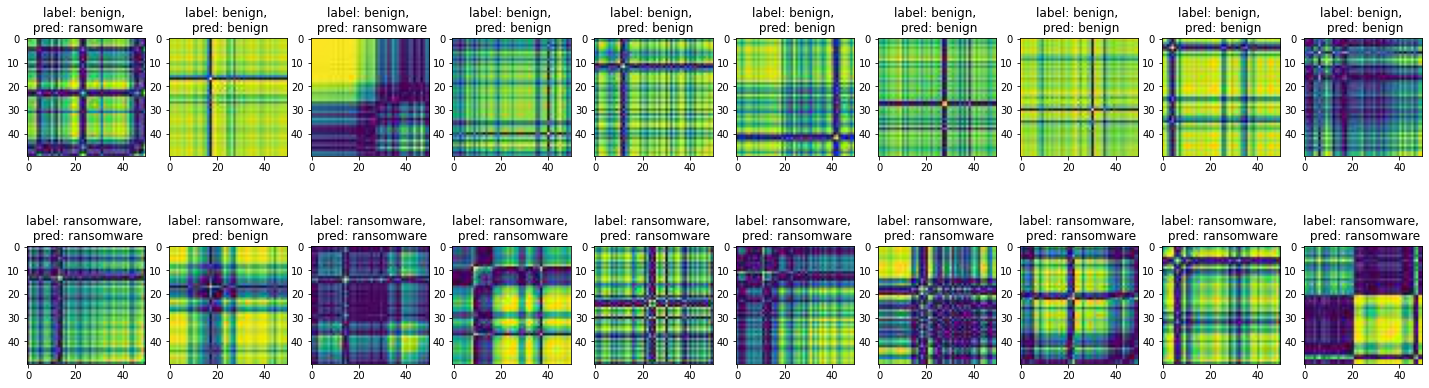

In [129]:
test_gaf_dataloader = DataLoader(test_gaf_dataset, batch_size=1, num_workers=0)
eval_model(test_gaf_dataloader, gaf_idx_to_class, validation_model_gaf)

## Experiment for Markov transition

In [133]:
benign_mtf_paths = ("features/images/benign/mtf/branch_instructions", "features/images/benign/mtf/cache_references")
ransomware_mtf_paths = ("features/images/ransomware/mtf/branch_instructions", "features/images/ransomware/mtf/cache_references")

benign_samples = 0
ransomware_samples = 0
sample_count = list()

for i in range(len(benign_gaf_paths)):
    benign_sample_count = len(glob.glob(os.path.join(benign_mtf_paths[i], "*")))
    sample_count.append(benign_sample_count)
    benign_samples += benign_sample_count

    ransomware_sample_count = len(glob.glob(os.path.join(ransomware_mtf_paths[i], "*")))
    sample_count.append(ransomware_sample_count)
    ransomware_samples += ransomware_sample_count

print("Benign samples", benign_samples)
print("Ransomware samples", ransomware_samples)
print("Min. samples", min(sample_count))

Benign samples 404
Ransomware samples 404
Min. samples 176


In [134]:
train_mtf_image_paths, valid_mtf_image_paths, test_mtf_image_paths, mtf_idx_to_class, mtf_class_to_idx = create_path_datasets(benign_mtf_paths, ransomware_mtf_paths, min(sample_count))

train_mtf_dataset = RansomwareDetectionDataset(train_mtf_image_paths, mtf_class_to_idx, transform=train_transformations)
validation_mtf_dataset = RansomwareDetectionDataset(valid_mtf_image_paths, mtf_class_to_idx, transform=validation_transformations)
test_mtf_dataset = RansomwareDetectionDataset(test_mtf_image_paths, mtf_class_to_idx, transform=test_transformation)

print(f"Tensor shape of the image: {train_mtf_dataset[1][0].shape}")
print(f"Label of the image: {mtf_idx_to_class[train_mtf_dataset[1][1]]}")

Test dataset len: 20
Train validation dataset len: 332
Path example: ('features/images/benign/mtf/branch_instructions/benign_226.jpg', 'features/images/benign/mtf/cache_references/benign_52.jpg')
Class example: benign
Train size: 232
Valid size 100
Class to idx: {'benign': 0, 'ransomware': 1}
Idx to class: {0: 'benign', 1: 'ransomware'}
Tensor shape of the image: torch.Size([6, 50, 50])
Label of the image: ransomware


In [135]:
train_mtf_loader, validation_mtf_loader = create_dataloaders(train_mtf_dataset, validation_mtf_dataset)

Train dataloader shape torch.Size([4, 6, 50, 50])
Validation dataloader shape torch.Size([4, 6, 50, 50])


In [136]:
mtf_model = BaselineNetwork(number_of_classes=len(mtf_idx_to_class), image_size=50)

In [137]:
checkpoint_callback_mtf = pl.callbacks.ModelCheckpoint(
    dirpath="checkpoints/MULTI-MTF",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="Loss/valid",
    mode="min"
)
logger_mtf = pl_loggers.TensorBoardLogger("logs/", name="MULTI-MTF")

trainer_mtf = pl.Trainer(max_epochs=20, log_every_n_steps=1, logger=logger_mtf, callbacks=[checkpoint_callback_mtf])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [138]:
trainer_mtf.fit(mtf_model, train_dataloaders=train_mtf_loader, val_dataloaders=validation_mtf_loader)

Missing logger folder: logs/MULTI-MTF

  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 660   
1 | conv2   | Conv2d           | 1.7 K 
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 1.3 M 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.164     Total estimated model params size (MB)


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 83/83 [00:03<00:00, 21.09it/s, loss=0.693, v_num=0, Loss/valid=0.693, Accuracy/valid=0.510, Loss/train=0.693, Accuracy/train=0.487]

Epoch 0, global step 57: Loss/valid reached 0.69308 (best 0.69308), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 1: 100%|██████████| 83/83 [00:04<00:00, 19.66it/s, loss=0.693, v_num=0, Loss/valid=0.693, Accuracy/valid=0.450, Loss/train=0.692, Accuracy/train=0.534]

Epoch 1, global step 115: Loss/valid was not in top 1


Epoch 2: 100%|██████████| 83/83 [00:03<00:00, 26.91it/s, loss=0.689, v_num=0, Loss/valid=0.699, Accuracy/valid=0.450, Loss/train=0.690, Accuracy/train=0.582]

Epoch 2, global step 173: Loss/valid was not in top 1


Epoch 3: 100%|██████████| 83/83 [00:02<00:00, 35.41it/s, loss=0.685, v_num=0, Loss/valid=0.694, Accuracy/valid=0.450, Loss/train=0.686, Accuracy/train=0.526]

Epoch 3, global step 231: Loss/valid was not in top 1


Epoch 4: 100%|██████████| 83/83 [00:02<00:00, 34.73it/s, loss=0.685, v_num=0, Loss/valid=0.693, Accuracy/valid=0.450, Loss/train=0.683, Accuracy/train=0.547]

Epoch 4, global step 289: Loss/valid reached 0.69278 (best 0.69278), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 5: 100%|██████████| 83/83 [00:02<00:00, 35.09it/s, loss=0.683, v_num=0, Loss/valid=0.689, Accuracy/valid=0.440, Loss/train=0.682, Accuracy/train=0.586]

Epoch 5, global step 347: Loss/valid reached 0.68874 (best 0.68874), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 6: 100%|██████████| 83/83 [00:02<00:00, 33.86it/s, loss=0.68, v_num=0, Loss/valid=0.679, Accuracy/valid=0.670, Loss/train=0.677, Accuracy/train=0.616] 

Epoch 6, global step 405: Loss/valid reached 0.67904 (best 0.67904), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 7: 100%|██████████| 83/83 [00:02<00:00, 32.57it/s, loss=0.668, v_num=0, Loss/valid=0.685, Accuracy/valid=0.420, Loss/train=0.669, Accuracy/train=0.711]

Epoch 7, global step 463: Loss/valid was not in top 1


Epoch 8: 100%|██████████| 83/83 [00:02<00:00, 39.25it/s, loss=0.663, v_num=0, Loss/valid=0.677, Accuracy/valid=0.610, Loss/train=0.661, Accuracy/train=0.716]

Epoch 8, global step 521: Loss/valid reached 0.67692 (best 0.67692), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 9: 100%|██████████| 83/83 [00:02<00:00, 36.26it/s, loss=0.654, v_num=0, Loss/valid=0.664, Accuracy/valid=0.720, Loss/train=0.652, Accuracy/train=0.720]

Epoch 9, global step 579: Loss/valid reached 0.66409 (best 0.66409), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 10: 100%|██████████| 83/83 [00:02<00:00, 38.63it/s, loss=0.618, v_num=0, Loss/valid=0.682, Accuracy/valid=0.450, Loss/train=0.634, Accuracy/train=0.746]

Epoch 10, global step 637: Loss/valid was not in top 1


Epoch 11: 100%|██████████| 83/83 [00:02<00:00, 36.75it/s, loss=0.582, v_num=0, Loss/valid=0.617, Accuracy/valid=0.780, Loss/train=0.603, Accuracy/train=0.746]

Epoch 11, global step 695: Loss/valid reached 0.61700 (best 0.61700), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 12: 100%|██████████| 83/83 [00:02<00:00, 38.10it/s, loss=0.546, v_num=0, Loss/valid=0.622, Accuracy/valid=0.730, Loss/train=0.567, Accuracy/train=0.780]

Epoch 12, global step 753: Loss/valid was not in top 1


Epoch 13: 100%|██████████| 83/83 [00:02<00:00, 35.33it/s, loss=0.514, v_num=0, Loss/valid=0.588, Accuracy/valid=0.750, Loss/train=0.552, Accuracy/train=0.711]

Epoch 13, global step 811: Loss/valid reached 0.58777 (best 0.58777), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 14: 100%|██████████| 83/83 [00:02<00:00, 37.03it/s, loss=0.496, v_num=0, Loss/valid=0.580, Accuracy/valid=0.770, Loss/train=0.532, Accuracy/train=0.763]

Epoch 14, global step 869: Loss/valid reached 0.58021 (best 0.58021), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/MULTI-MTF/best-checkpoint.ckpt" as top 1


Epoch 15: 100%|██████████| 83/83 [00:02<00:00, 33.36it/s, loss=0.529, v_num=0, Loss/valid=0.593, Accuracy/valid=0.690, Loss/train=0.493, Accuracy/train=0.784]

Epoch 15, global step 927: Loss/valid was not in top 1


Epoch 16: 100%|██████████| 83/83 [00:02<00:00, 35.99it/s, loss=0.51, v_num=0, Loss/valid=0.604, Accuracy/valid=0.720, Loss/train=0.460, Accuracy/train=0.797] 

Epoch 16, global step 985: Loss/valid was not in top 1


Epoch 17: 100%|██████████| 83/83 [00:02<00:00, 31.48it/s, loss=0.473, v_num=0, Loss/valid=0.591, Accuracy/valid=0.750, Loss/train=0.492, Accuracy/train=0.772]

Epoch 17, global step 1043: Loss/valid was not in top 1


Epoch 18: 100%|██████████| 83/83 [00:02<00:00, 34.52it/s, loss=0.45, v_num=0, Loss/valid=0.663, Accuracy/valid=0.660, Loss/train=0.437, Accuracy/train=0.806] 

Epoch 18, global step 1101: Loss/valid was not in top 1


Epoch 19: 100%|██████████| 83/83 [00:02<00:00, 35.73it/s, loss=0.405, v_num=0, Loss/valid=0.602, Accuracy/valid=0.720, Loss/train=0.440, Accuracy/train=0.793]

Epoch 19, global step 1159: Loss/valid was not in top 1


Epoch 19: 100%|██████████| 83/83 [00:02<00:00, 35.64it/s, loss=0.405, v_num=0, Loss/valid=0.602, Accuracy/valid=0.720, Loss/train=0.440, Accuracy/train=0.793]


In [139]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 18015), started 1:02:16 ago. (Use '!kill 18015' to kill it.)

### Verify the model

In [140]:
validation_model_mtf = BaselineNetwork(number_of_classes=len(mtf_idx_to_class), image_size=50)
checkpoint_mtf = torch.load("checkpoints/MULTI-MTF/best-checkpoint.ckpt")

validation_model_mtf.load_state_dict(checkpoint_mtf["state_dict"])
validation_model_mtf.eval()

BaselineNetwork(
  (conv1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=10000, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
  (loss): CrossEntropyLoss()
)

              precision    recall  f1-score   support

      benign       0.75      0.90      0.82        10
  ransomware       0.88      0.70      0.78        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



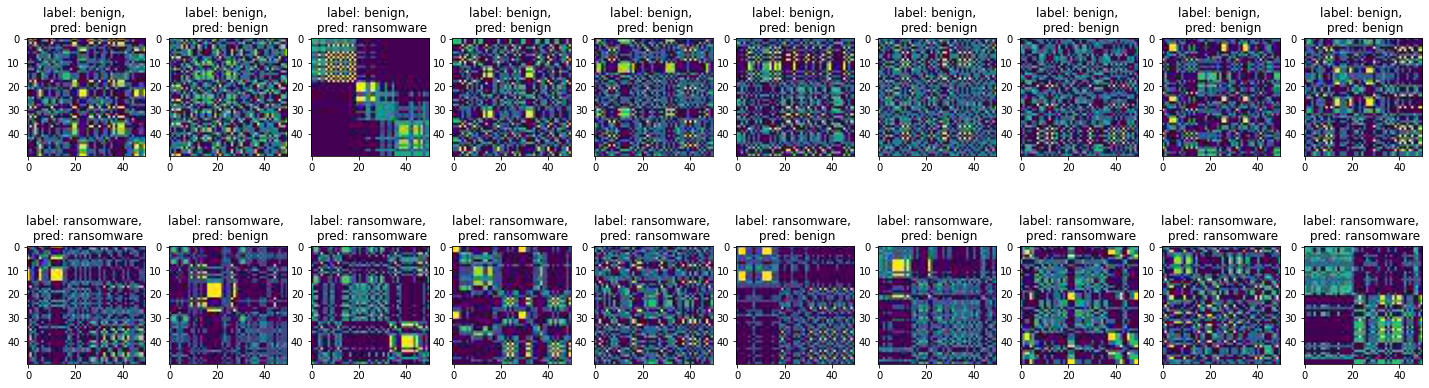

In [141]:
test_mtf_dataloader = DataLoader(test_mtf_dataset, batch_size=1, num_workers=0)
eval_model(test_mtf_dataloader, mtf_idx_to_class, validation_model_mtf)